In [ ]:
# connecting Google colab to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import all the Dependencies


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
# Setting up the constants
image_size = 256
batch_size = 32
channels = 3
epochs = 50

Importing data set from Google drive into tensorflow dataset object

In [ ]:
# We will use image_dataset_from_directory api to load all images in tensorflow dataset:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/comp",
    shuffle = True,
    image_size = (image_size,image_size),
    batch_size = batch_size
    )

Found 6224 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

195

**Visualize some of the images from our dataset**



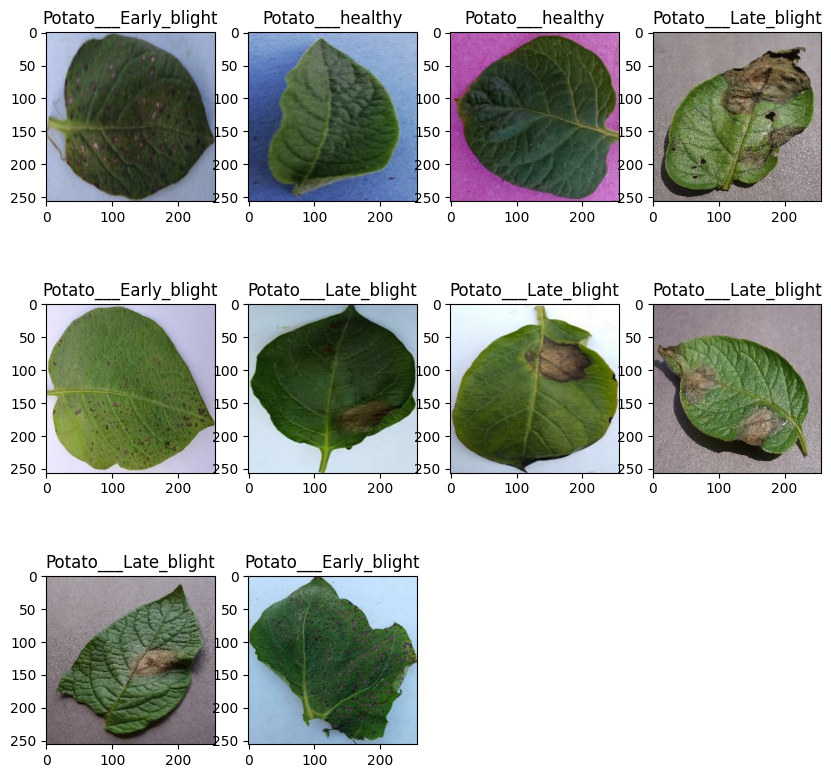

In [ ]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(10):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
  #plt.axis("off")

In [ ]:
# Function to split data in ration of 8:1:1, where 80% data is for training, 10% is for validation and 10% is for testing.
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

156

In [ ]:
len(val_ds)

19

In [ ]:
len(test_ds)

20

In [ ]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

**Creating a Layer for Resizing and Normalization**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

**Data Augmentation**

Data Augmentation is needed to boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**

In [ ]:
input_shape = (batch_size,image_size ,image_size, channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    ])
model.build(input_shape = input_shape)

In [ ]:
# Displaying Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

**Compiling the Model**

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 359s 1s/step - loss: 1.0346 - accuracy: 0.4028 - val_loss: 0.9735 - val_accuracy: 0.5104
Epoch 2/50
54/54 [==============================] - 18s 338ms/step - loss: 0.9047 - accuracy: 0.5799 - val_loss: 0.7442 - val_accuracy: 0.6354
Epoch 3/50
54/54 [==============================] - 18s 332ms/step - loss: 0.6711 - accuracy: 0.7054 - val_loss: 0.5963 - val_accuracy: 0.7240
Epoch 4/50
54/54 [==============================] - 17s 320ms/step - loss: 0.5033 - accuracy: 0.7650 - val_loss: 0.6972 - val_accuracy: 0.7656
Epoch 5/50
54/54 [==============================] - 18s 331ms/step - loss: 0.3902 - accuracy: 0.8362 - val_loss: 0.4382 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 18s 332ms/step - loss: 0.3371 - accuracy: 0.8738 - val_loss: 0.5572 - val_accuracy: 0.7760
Epoch 7/50
54/54 [==============================] - 18s 328ms/step - loss: 0.3411 - accuracy: 0.8628 - val_loss: 0.3184 - val_accuracy: 0.8958
E

In [ ]:
score = model.evaluate(test_ds)

20/20 [==============================] - 4s 66ms/step - loss: 0.1984 - accuracy: 0.9547


In [ ]:
score

[0.198425754904747, 0.9546874761581421]

**Plotting the Accuracy and Loss Curves**

In [ ]:
history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc  = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

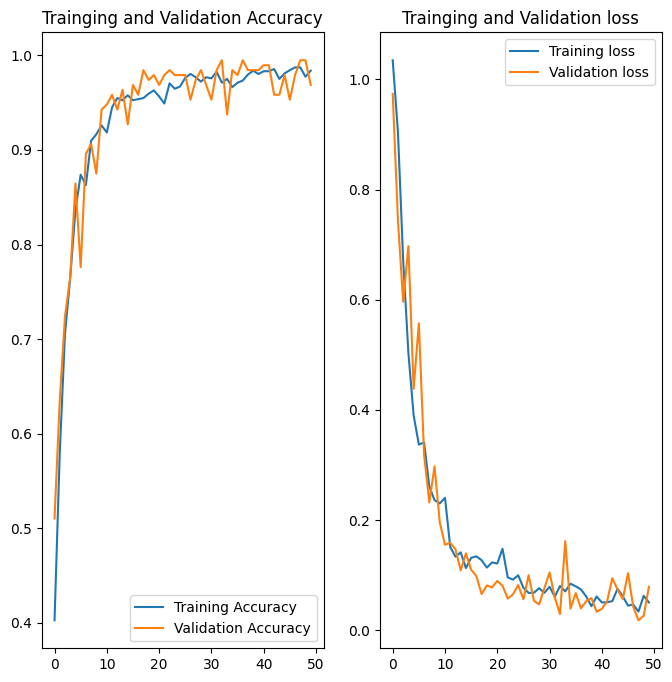

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc, label = 'Training Accuracy')
plt.plot(range(epochs),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Trainging and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss, label = 'Training loss')
plt.plot(range(epochs),val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Trainging and Validation loss')
plt.show()

**Running prediction on a sample image**

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_name[first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label:", class_name [np.argmax(batch_prediction[0])])

**Writing a function for inference**

In [ ]:
 def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_name[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])),2)
  return predicted_class, confidence

Now running inference on few sample images

1/1 [==============================] - 0s 28ms/step


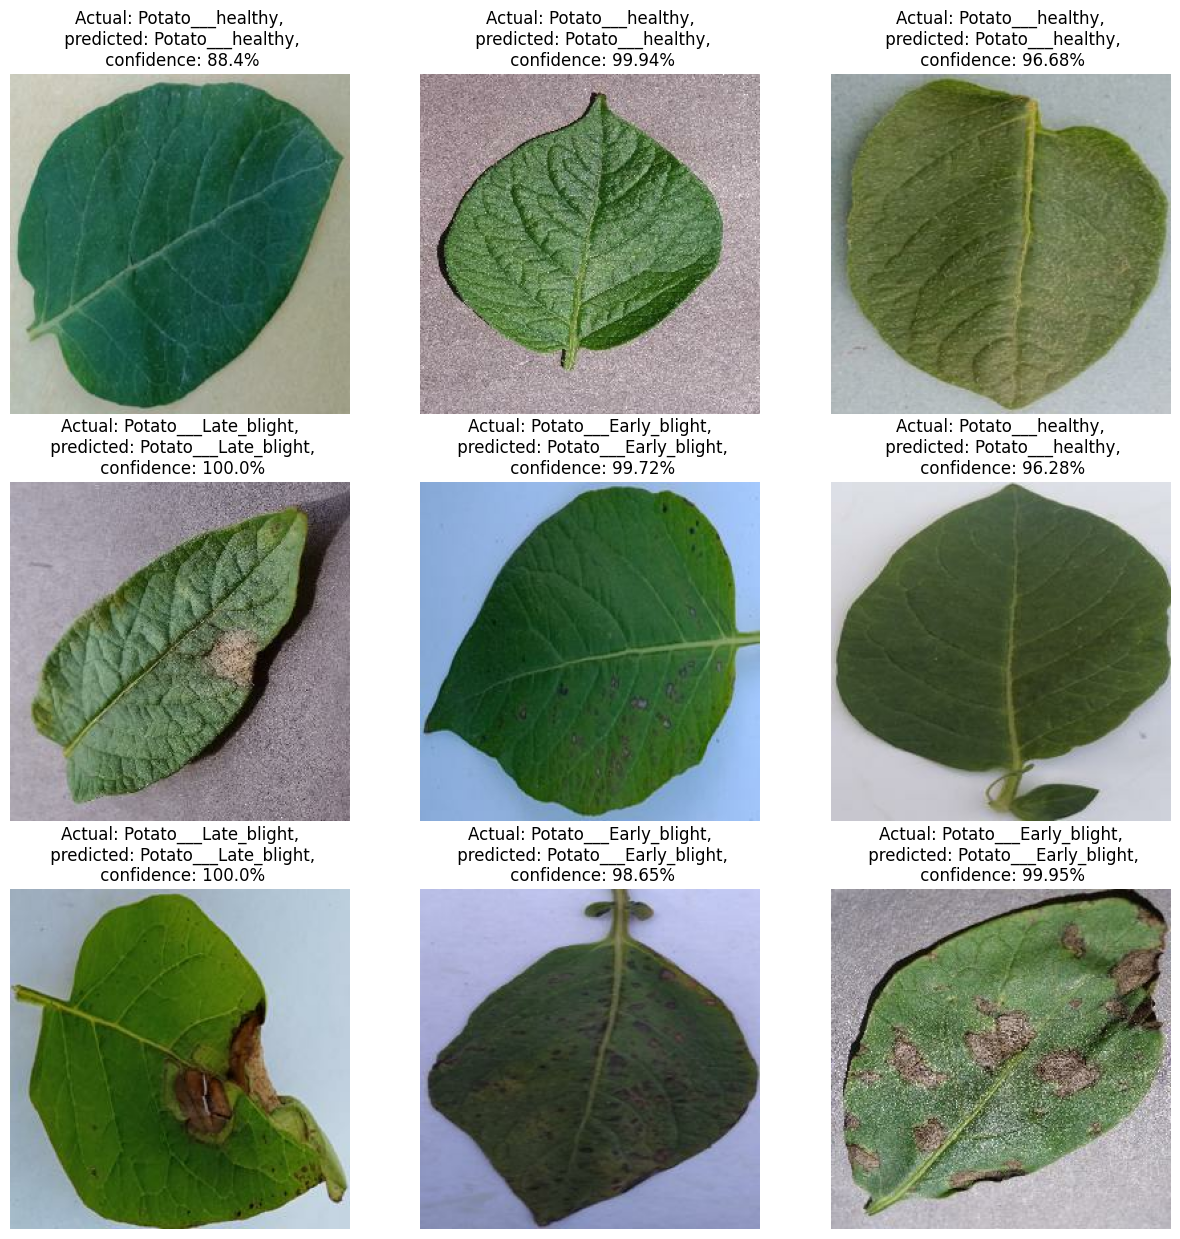

In [ ]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_name[labels[i]]
    plt.title(f"Actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}%")

    plt.axis('off')

**Saving the Model**

In [ ]:
model_version = 1
model.save("model_version.h5")

In [ ]:
#!tar -czvf model.tar.gz model_version./

In [ ]:
#!zip -r log.zip /content/model_version